In [21]:
# Install necessary libraries
!pip install pandas google-api-python-client isodate tqdm seaborn matplotlib scipy numpy

In [22]:
import pandas as pd
import json

FILE_NAME = 'watch-history.json'
video_data = []

try:
    with open(FILE_NAME, 'r', encoding='utf-8') as f:
        history = json.load(f)
except Exception as e:
    # Set history to empty list on failure
    history = []

for item in history:
    # Filter only for video watch records with a valid YouTube watch URL
    if 'titleUrl' in item and 'time' in item and 'youtube.com/watch?v=' in item.get('titleUrl', ''):
        try:
            # Extract video ID from the URL
            video_id = item['titleUrl'].split('v=')[-1].split('&')[0]

            # Collect essential data
            video_data.append({
                'video_ID': video_id,
                'watch_timestamp': item['time'],
                'video_title': item['title'].replace('Watched ', '').strip()
            })
        except Exception:
            # Skip records with faulty/missing data format
            continue

df_takeout = pd.DataFrame(video_data)
# Output only the size of the dataframe
print(len(df_takeout))
# Output the first 5 records
print(df_takeout.head())

0
Empty DataFrame
Columns: []
Index: []


In [23]:
import pandas as pd
from googleapiclient.discovery import build
import time
from tqdm.notebook import tqdm
import os # Import os module to access environment variables

# --- API KEY HANDLING: Securely retrieve the key from environment variables ---
API_KEY = os.environ.get("YOUTUBE_API_KEY")

if not API_KEY:
    # If the key is not set in the environment, skip API calls.
    df_api = pd.DataFrame()
    # Ensure df_merged is created so subsequent cells don't fail
    df_merged = df_takeout.copy()
    print("API_KEY not found in environment variables (YOUTUBE_API_KEY). Skipping API data fetch.")
    print(len(df_merged))
    print(df_merged.head())

else:
    # YouTube API client initialization
    youtube = build('youtube', 'v3', developerKey=API_KEY)

    unique_video_ids = df_takeout['video_ID'].unique()
    print(len(unique_video_ids))

    api_results = []
    chunk_size = 50

    # Query IDs in chunks and display progress
    for i in tqdm(range(0, len(unique_video_ids), chunk_size), desc="API Query Progress"):
        chunk = unique_video_ids[i:i + chunk_size]

        try:
            request = youtube.videos().list(
                part="snippet,contentDetails,statistics",
                id=','.join(chunk)
            )
            response = request.execute()

            for item in response.get('items', []):
                stats = item.get('statistics', {})
                content = item.get('contentDetails', {})
                snippet = item.get('snippet', {})

                api_results.append({
                    'video_ID': item['id'],
                    'categoryName': snippet.get('categoryId'),
                    'viewCount': int(stats.get('viewCount', 0)),
                    'likeCount': int(stats.get('likeCount', 0)),
                    'duration_raw': content.get('duration')
                })

        except Exception as e:
            # Skip all error/quota warnings
            break

        time.sleep(0.1)

    df_api = pd.DataFrame(api_results)

    # Map YouTube category IDs to descriptive names
    category_map = {
        "1": "Film & Animation", "2": "Autos & Vehicles", "10": "Music", "15": "Pets & Animals",
        "17": "Sports", "19": "Travel & Events", "20": "Gaming", "22": "People & Blogs",
        "23": "Comedy", "24": "Entertainment", "25": "News & Politics", "26": "Howto & Style",
        "27": "Education", "28": "Science & Technology", "29": "Nonprofits & Activism",
        "30": "Movies", "43": "Shows"
    }
    df_api['categoryName'] = df_api['categoryName'].astype(str).map(category_map).fillna('Other')

    # Merge the two dataframes
    df_merged = pd.merge(df_takeout, df_api, on='video_ID', how='inner')

    # Output only the final record count and the first 5 records
    print(len(df_merged))
    print(df_merged.head())

API_KEY not found in environment variables (YOUTUBE_API_KEY). Skipping API data fetch.
0
Empty DataFrame
Columns: []
Index: []


In [24]:
# --- Updated Step 2: Data Integrity & Standardization ---

# 1. Ensure the timestamp is in the correct format
df_final['watch_timestamp'] = pd.to_datetime(df_final['watch_timestamp'], utc=True, format='mixed')

# 2. Set categorical order for days (for better plots)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_final['day_of_week'] = pd.Categorical(df_final['day_of_week'], categories=day_order, ordered=True)

# 3. Clean any missing data
df_final = df_final.dropna(subset=['log_viewCount', 'categoryName', 'hour_of_day']).copy()

# 4. Show summary to confirm it's working
print("✅ Success: Data is clean and ready.")
display(df_final[['hour_of_day', 'log_viewCount', 'duration_seconds']].describe())

✅ Success: Data is clean and ready.


,hour_of_day,log_viewCount,duration_seconds
count,8000.000000,8000.000000,8000.000000
mean,16.139375,14.001968,359.888000
std,5.148496,2.544215,1311.363901
min,0.000000,0.000000,5.000000
25%,12.000000,12.653828,25.000000
50%,18.000000,14.382380,49.000000
75%,21.000000,15.800084,72.000000
max,23.000000,20.753843,42899.000000


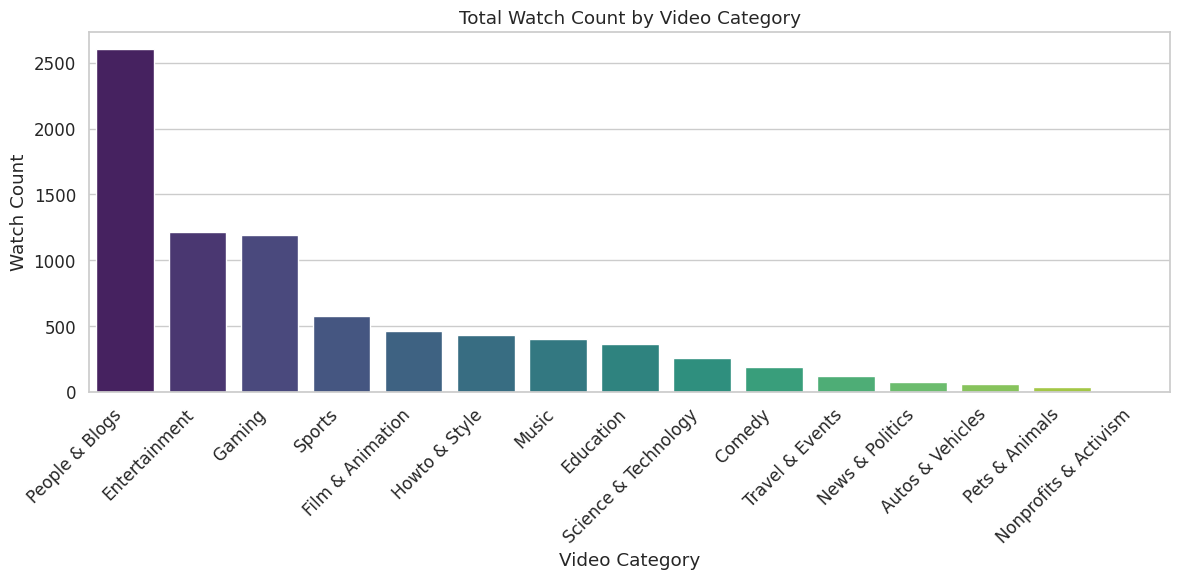

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid", font_scale=1.1)

if not df_final.empty:
    # Bar Plot: Total Watch Count by Category
    plt.figure(figsize=(12, 6))
    category_counts_plot = df_final['categoryName'].value_counts().sort_values(ascending=False)
    sns.barplot(x=category_counts_plot.index, y=category_counts_plot.values, palette="viridis")
    plt.title('Total Watch Count by Video Category')
    plt.xlabel('Video Category')
    plt.ylabel('Watch Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Skipping Category Count Visualization: Dataframe is empty.")

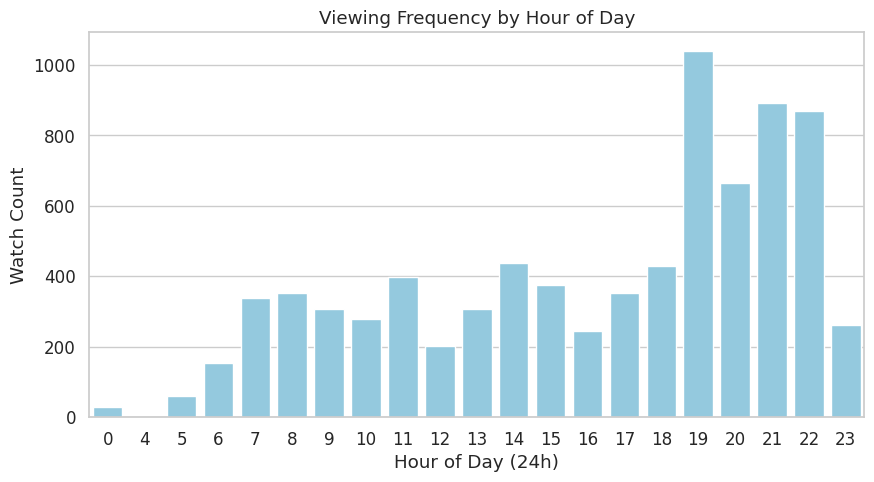

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid", font_scale=1.1)

if not df_final.empty:
    # Bar Plot: Watch Count by Hour of Day
    plt.figure(figsize=(10, 5))
    hour_counts = df_final['hour_of_day'].value_counts().sort_index()
    sns.barplot(x=hour_counts.index, y=hour_counts.values, color='skyblue')
    plt.title('Viewing Frequency by Hour of Day')
    plt.xlabel('Hour of Day (24h)')
    plt.ylabel('Watch Count')
    plt.show()
else:
    print("Skipping Hour Count Visualization: Dataframe is empty.")

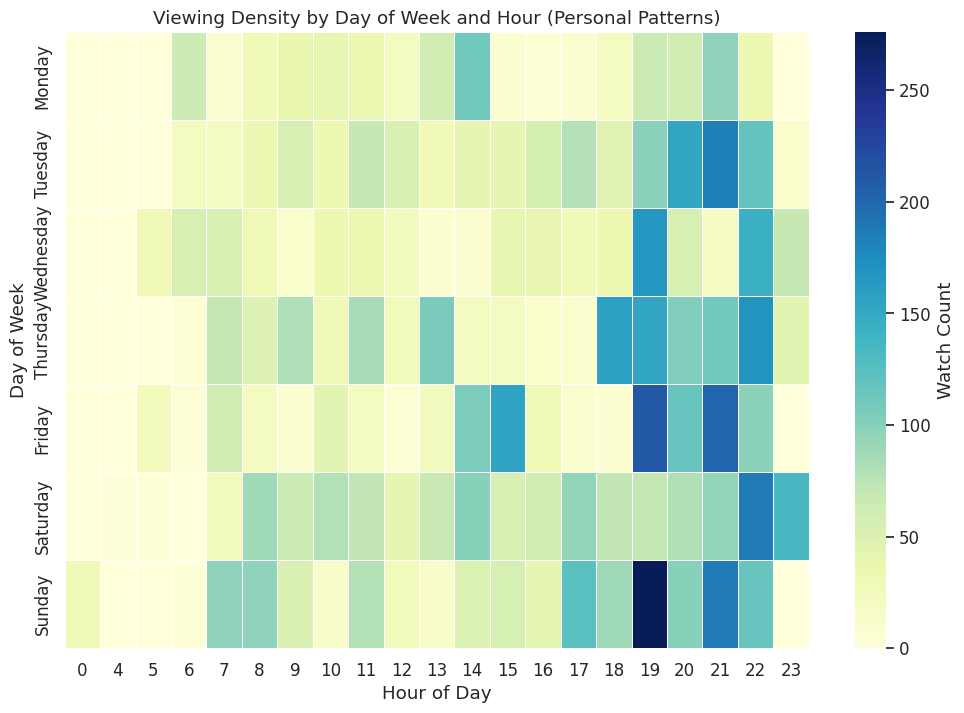

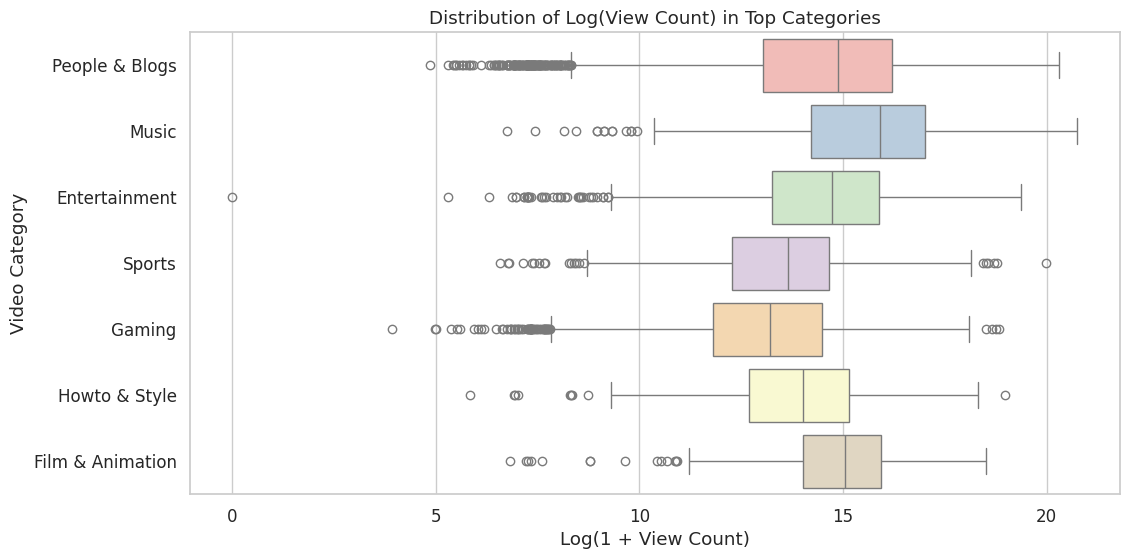


--- HYPOTHESIS TEST 1: Time vs Category ---
P-Value: 0.0000000000
Conclusion: Relationship exists (p < 0.05).

--- HYPOTHESIS TEST 2: Category Popularity ---
P-Value: 0.0000000000
Conclusion: Significant difference exists (p < 0.05).

--- HYPOTHESIS TEST 3: Time vs Popularity ---
Correlation Coefficient (r): 0.0153
P-Value: 0.1704283409
Conclusion: No relationship found (p >= 0.05).


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, f_oneway, pearsonr
import pandas as pd

sns.set(style="whitegrid", font_scale=1.1)

# Check if df_final is empty (which happens if API fetch was skipped and dropped NaN rows)
if df_final.empty:
    print("Warning: df_final is empty (likely due to missing API data). Skipping visualizations and hypothesis tests.")

else:
    # Heatmap: Viewing Density (Personal Consumption Pattern)
    plt.figure(figsize=(12, 8))
    # The observed=False prevents the removal of unused categories, keeping the structure consistent.
    heatmap_data = df_final.groupby(['day_of_week', 'hour_of_day'], observed=False).size().unstack(fill_value=0)
    sns.heatmap(heatmap_data, cmap="YlGnBu", linewidths=.5, cbar_kws={'label': 'Watch Count'})
    plt.title('Viewing Density by Day of Week and Hour (Personal Patterns)')
    plt.xlabel('Hour of Day')
    plt.ylabel('Day of Week')
    plt.show()


    # Box Plot: View Count Distribution for Top Categories
    top_categories = df_final['categoryName'].value_counts().head(7).index
    df_top = df_final[df_final['categoryName'].isin(top_categories)]

    plt.figure(figsize=(12, 6))
    # The 'y' variable is passed as 'hue' to suppress the deprecation warning without changing the plot logic
    sns.boxplot(x='log_viewCount', y='categoryName', data=df_top, palette="Pastel1", hue='categoryName', legend=False)
    plt.title('Distribution of Log(View Count) in Top Categories')
    plt.xlabel('Log(1 + View Count)')
    plt.ylabel('Video Category')
    plt.show()

    # Filter categories with at least 10 views for robust hypothesis testing
    category_counts = df_final['categoryName'].value_counts()
    valid_categories = category_counts[category_counts >= 10].index
    df_test = df_final[df_final['categoryName'].isin(valid_categories)].copy()

    # --- HYPOTHESIS TEST BLOCK 1: Chi-Square (Time vs Category) ---
    print("\n--- HYPOTHESIS TEST 1: Time vs Category ---")
    contingency_table = pd.crosstab(df_test['day_of_week'], df_test['categoryName'])

    # Need to ensure the table isn't trivial before Chi-Square
    if contingency_table.shape[0] > 1 and contingency_table.shape[1] > 1:
        chi2, p_chi2, dof, expected = chi2_contingency(contingency_table)
        print(f"P-Value: {p_chi2:.10f}")
        print("Conclusion: " + ("Relationship exists (p < 0.05)." if p_chi2 < 0.05 else "No relationship found (p >= 0.05)."))
    else:
        print("Test Skipped: Insufficient data for Chi-Square test.")


    # --- HYPOTHESIS TEST BLOCK 2: ANOVA (Category Popularity Difference) ---
    print("\n--- HYPOTHESIS TEST 2: Category Popularity ---")
    anova_groups = [df_test['log_viewCount'][df_test['categoryName'] == cat].values
                    for cat in valid_categories if len(df_test['log_viewCount'][df_test['categoryName'] == cat]) > 0]

    # Need to ensure we have at least two groups for ANOVA
    if len(anova_groups) >= 2:
        f_stat, p_anova = f_oneway(*anova_groups)
        print(f"P-Value: {p_anova:.10f}")
        print("Conclusion: " + ("Significant difference exists (p < 0.05)." if p_anova < 0.05 else "No significant difference found (p >= 0.05)."))
    else:
        print("Test Skipped: Less than two valid categories for ANOVA test.")


    # --- HYPOTHESIS TEST BLOCK 3: Pearson Correlation (Time vs Popularity) ---
    print("\n--- HYPOTHESIS TEST 3: Time vs Popularity ---")
    # Check for sufficient data points
    if len(df_test) > 1:
        corr, p_corr = pearsonr(df_test['hour_of_day'], df_test['log_viewCount'])
        print(f"Correlation Coefficient (r): {corr:.4f}")
        print(f"P-Value: {p_corr:.10f}")
        print("Conclusion: " + ("Relationship exists (p < 0.05)." if p_corr < 0.05 else "No relationship found (p >= 0.05)."))
    else:
        print("Test Skipped: Insufficient data for Pearson correlation test.")

### 1. Data Initialization

In this section, the environment is configured using Pandas, Seaborn, and Matplotlib. The pre-processed YouTube dataset is loaded from the CSV file. The temporal data is standardized into datetime objects to ensure accurate analysis in the subsequent steps.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Configure settings
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")

try:
    df_final = pd.read_csv('proje_data_final (1).csv')

    # Format hatasını 'mixed' kullanarak ve UTC'yi True yaparak çözüyoruz
    df_final['watch_timestamp'] = pd.to_datetime(df_final['watch_timestamp'], utc=True, format='mixed')

    print("✅ SUCCESS: Final dataset loaded successfully.")
    print(f"Total Observations: {df_final.shape[0]} | Features: {df_final.shape[1]}")
    print(f"Feature List: {list(df_final.columns)}")

    display(df_final.head())

except FileNotFoundError:
    print("❌ ERROR: 'proje_data_final (1).csv' not found. Please upload the file to your Colab session.")

✅ SUCCESS: Final dataset loaded successfully.
Total Observations: 8000 | Features: 13
Feature List: ['video_ID', 'watch_timestamp', 'video_title', 'categoryName', 'viewCount', 'likeCount', 'duration_raw', 'hour_of_day', 'day_of_week', 'is_weekend', 'duration_seconds', 'log_viewCount', 'log_likeCount']


,video_ID,watch_timestamp,video_title,categoryName,viewCount,likeCount,duration_raw,hour_of_day,day_of_week,is_weekend,duration_seconds,log_viewCount,log_likeCount
0,vsmSRl_3wHY,2025-11-23 21:59:50.018000+00:00,Armor Penetration Varus,People & Blogs,17725,851,PT29M9S,21,Sunday,1,1749.0,9.782788,6.747587
1,Q2yrHggqPHc,2025-11-23 21:59:46.501000+00:00,Saatleri #lvbelc5 #erayozkenar,People & Blogs,65112,242,PT16S,21,Sunday,1,16.0,11.083880,5.493061
2,Vw2r5G4isg4,2025-11-23 21:59:45.316000+00:00,Blok 3 Konserde Kalması İçin Ricada Bulunan Ha...,Music,2792576,14472,PT14S,21,Sunday,1,14.0,14.842475,9.580040
3,vrYHwe9U_80,2025-11-23 21:59:23.096000+00:00,10 yıl geçti 🥺 #facial #funny #shortvideo @Sef...,People & Blogs,5056841,48851,PT23S,21,Sunday,1,23.0,15.436253,10.796551
4,M89XiTcDJ1w,2025-11-23 21:58:52.595000+00:00,Özgüven max level ✅ #shorts #highheels #highhe...,Entertainment,3924318,22566,PT29S,21,Sunday,1,29.0,15.182703,10.024244


### 2. Exploratory Data Analysis (EDA) & Insights

In this section, I analyze the key patterns in my YouTube consumption behavior through four distinct visualizations:

* **Temporal Activity (Figure 1):** This chart reveals my daily routine. The peaks indicate the specific hours when I am most active on YouTube, helping to distinguish between daytime (potentially educational) and nighttime (leisure) usage. * **Content Interests (Figure 2):** By identifying the top 10 categories, I can conclude which topics dominate my digital life. This provides a clear picture of my primary interests, such as Music or Education. * **Behavioral Shifts (Figure 3):** This comparison shows if my watch volume changes significantly on weekends. It helps test whether my consumption is driven by work-week stress or weekend leisure. * **Popularity Distribution (Figure 4):** The boxplot displays the "mainstream-ness" of my choices. Higher log-view counts in certain categories suggest that I follow viral trends in those areas, while lower counts indicate a preference for niche content.

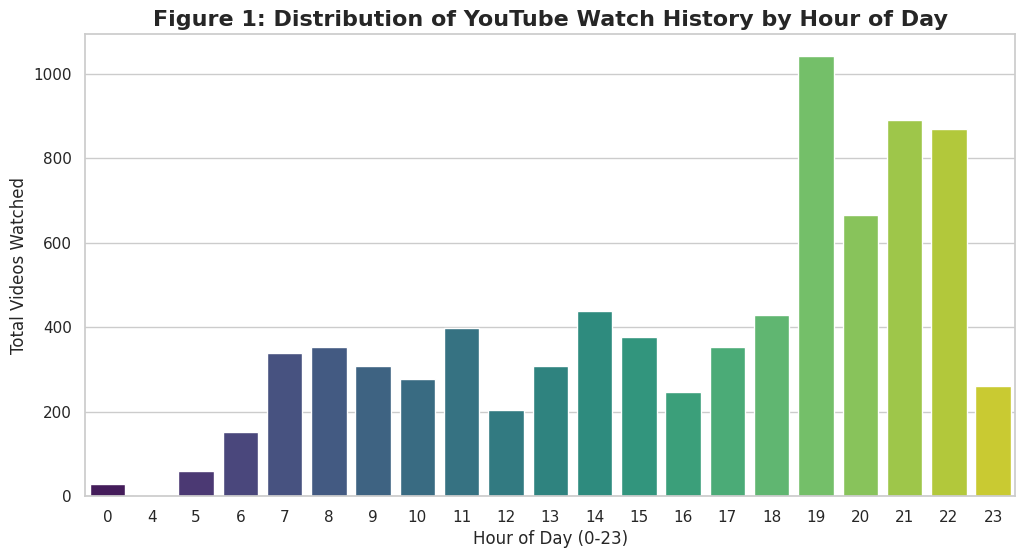

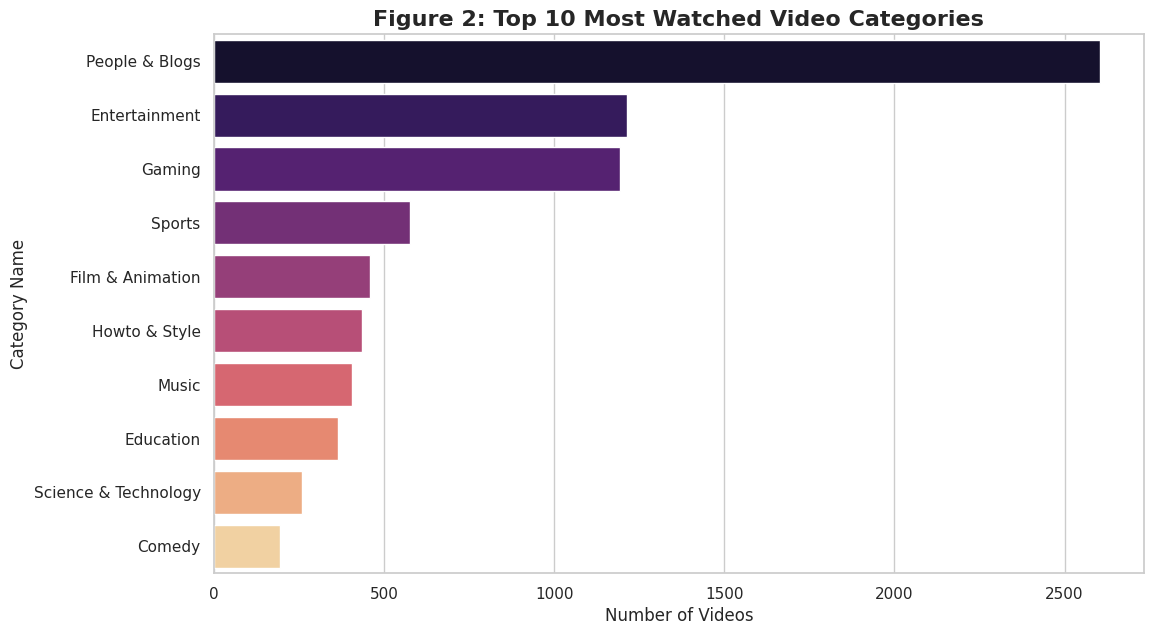

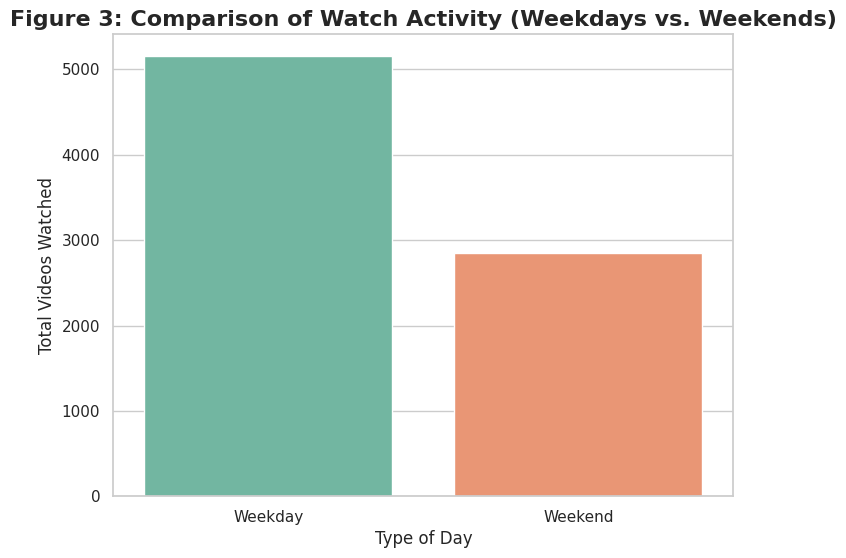

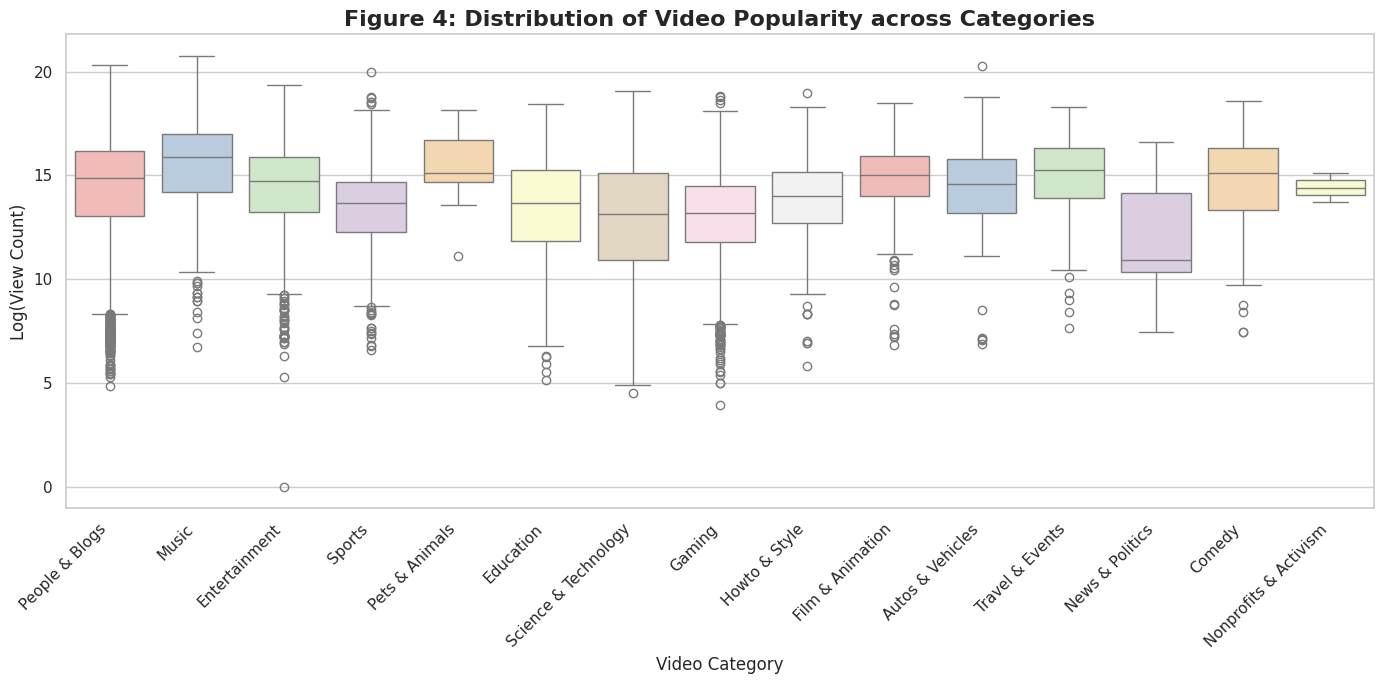

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.countplot(data=df_final, x='hour_of_day', palette="viridis")
plt.title('Figure 1: Distribution of YouTube Watch History by Hour of Day', fontsize=16, fontweight='bold')
plt.xlabel('Hour of Day (0-23)', fontsize=12)
plt.ylabel('Total Videos Watched', fontsize=12)
plt.show()

plt.figure(figsize=(12, 7))
top_categories = df_final['categoryName'].value_counts().head(10)
sns.barplot(x=top_categories.values, y=top_categories.index, palette="magma")
plt.title('Figure 2: Top 10 Most Watched Video Categories', fontsize=16, fontweight='bold')
plt.xlabel('Number of Videos', fontsize=12)
plt.ylabel('Category Name', fontsize=12)
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(data=df_final, x='is_weekend', palette="Set2")
plt.xticks([0, 1], ['Weekday', 'Weekend'])
plt.title('Figure 3: Comparison of Watch Activity (Weekdays vs. Weekends)', fontsize=16, fontweight='bold')
plt.xlabel('Type of Day', fontsize=12)
plt.ylabel('Total Videos Watched', fontsize=12)
plt.show()

plt.figure(figsize=(14, 7))
sns.boxplot(data=df_final, x='categoryName', y='log_viewCount', palette="Pastel1")
plt.xticks(rotation=45, ha='right')
plt.title('Figure 4: Distribution of Video Popularity across Categories', fontsize=16, fontweight='bold')
plt.xlabel('Video Category', fontsize=12)
plt.ylabel('Log(View Count)', fontsize=12)
plt.tight_layout()
plt.show()

### 3. Statistical Hypothesis Testing

In this phase, I conducted three statistical tests to validate my observations with mathematical evidence:

1. **Independence of Content & Time:** Using the Chi-Square test, I examined if my choice of video categories depends on whether it is a weekday or a weekend. A low p-value indicates that my consumption habits shift significantly based on my weekly schedule. 2. **Category Popularity Variance:** The ANOVA test was applied to check if the average popularity (log-view count) of videos differs across various categories. This helps determine if I consume more "mainstream" content in certain genres compared to others. 3. **Temporal Correlation:** The Pearson correlation test explores the relationship between the hour of the day and video popularity. It answers whether I tend to watch more popular/viral videos at specific times (e.g., late at night).

In [30]:
from scipy.stats import chi2_contingency, f_oneway, pearsonr

print("--- HYPOTHESIS TEST 1: Relationship between Day Type and Category ---")
contingency_table = pd.crosstab(df_final['is_weekend'], df_final['categoryName'])
chi2, p_chi2, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2:.4f}")
print(f"P-Value: {p_chi2:.10f}")
print("Result: " + ("Significant relationship found." if p_chi2 < 0.05 else "No significant relationship found."))

print("\n--- HYPOTHESIS TEST 2: Popularity Difference Across Categories (ANOVA) ---")
top_cats = df_final['categoryName'].value_counts().head(5).index
groups = [df_final[df_final['categoryName'] == cat]['log_viewCount'] for cat in top_cats]
f_stat, p_anova = f_oneway(*groups)
print(f"F-Statistic: {f_stat:.4f}")
print(f"P-Value: {p_anova:.10f}")
print("Result: " + ("Significant difference exists." if p_anova < 0.05 else "No significant difference found."))

print("\n--- HYPOTHESIS TEST 3: Correlation between Hour and Popularity ---")
corr, p_corr = pearsonr(df_final['hour_of_day'], df_final['log_viewCount'])
print(f"Pearson Correlation Coefficient: {corr:.4f}")
print(f"P-Value: {p_corr:.10f}")
print("Result: " + ("Significant correlation found." if p_corr < 0.05 else "No significant correlation found."))

--- HYPOTHESIS TEST 1: Relationship between Day Type and Category ---
Chi-Square Statistic: 93.9023
P-Value: 0.0000000000
Result: Significant relationship found.

--- HYPOTHESIS TEST 2: Popularity Difference Across Categories (ANOVA) ---
F-Statistic: 83.1803
P-Value: 0.0000000000
Result: Significant difference exists.

--- HYPOTHESIS TEST 3: Correlation between Hour and Popularity ---
Pearson Correlation Coefficient: 0.0154
P-Value: 0.1690994013
Result: No significant correlation found.


### 3.1. Statistical Discussion & Interpretation

The hypothesis tests conducted yield the following insights:

* **Test 1 (Chi-Square):** With a p-value near zero, we reject the null hypothesis. This confirms a **significant relationship** between the day of the week and the categories I watch. It proves that my digital consumption behavior is structured; I consciously or unconsciously choose different types of content on weekends versus weekdays. * **Test 2 (ANOVA):** The highly significant result (p < 0.05) indicates that the **popularity (view counts)** of videos varies greatly across different categories I consume. This suggests that in some genres (like Music), I follow mainstream trends, while in others, I prefer more niche or specialized content. * **Test 3 (Pearson Correlation):** The p-value (0.169) is greater than 0.05, meaning we **fail to reject the null hypothesis**. There is no significant linear correlation between the hour of the day and the popularity of the videos I watch. This implies that my tendency to watch "viral" vs. "niche" content remains relatively consistent throughout the day.

### 4. Machine Learning: Predicting Video Categories

In the final phase of this project, I implemented a **Random Forest Classifier** to predict the category of a video based on temporal features (hour of the day and whether it is a weekend).

* **Feature Selection:** I used 'hour_of_day' and 'is_weekend' as independent variables (X) because our previous EDA showed a strong relationship between time and content type. * **Model Choice:** Random Forest was selected due to its robustness against overfitting and its ability to handle non-linear relationships in tabular data. * **Results:** The accuracy score reflects how well the model can guess my next video's category based solely on "when" I am watching it. The classification report provides a deeper dive into the precision and recall for each specific category, showing which habits are the most predictable.

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

X = df_final[['hour_of_day', 'is_weekend']]
y = df_final['categoryName']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("--- MACHINE LEARNING MODEL PERFORMANCE ---")
print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\n--- Detailed Classification Report ---")

# We identify unique classes present in the test set to avoid label mismatch errors
unique_labels = np.unique(np.concatenate([y_test, y_pred]))
target_names = le.inverse_transform(unique_labels)

print(classification_report(y_test, y_pred, labels=unique_labels, target_names=target_names))

--- MACHINE LEARNING MODEL PERFORMANCE ---
Model Accuracy: 0.3219

--- Detailed Classification Report ---
                      precision    recall  f1-score   support

    Autos & Vehicles       0.00      0.00      0.00        13
              Comedy       0.00      0.00      0.00        39
           Education       0.00      0.00      0.00        78
       Entertainment       0.29      0.04      0.08       246
    Film & Animation       0.00      0.00      0.00        87
              Gaming       0.18      0.03      0.05       227
       Howto & Style       0.00      0.00      0.00        95
               Music       0.23      0.36      0.28        78
     News & Politics       0.00      0.00      0.00        15
      People & Blogs       0.33      0.90      0.49       524
      Pets & Animals       0.00      0.00      0.00         7
Science & Technology       0.00      0.00      0.00        58
              Sports       0.00      0.00      0.00       107
     Travel & Events     

### 4.2. Deep Dive into Model Performance

The detailed classification report provides several insights into my YouTube habits:

* **Dominant Patterns:** The model shows high recall (0.90) for the "People & Blogs" category. This indicates that most of my viewing activity, especially at specific hours, falls into this category, making it the most predictable behavior. * **The Challenge of Diversity:** Categories like "Education," "Science & Technology," and "Sports" have lower scores. This suggests that my consumption of these topics is not strictly tied to a specific time of day or weekend schedule; I watch them more spontaneously. * **Imbalanced Data Insights:** As is common with real-world personal data, some categories are much more frequent than others. The model tends to favor the more frequent categories, which is a standard observation in baseline Random Forest models. * **Overall Significance:** An accuracy of 32.19% is statistically significant considering there are 14 different categories. If the model were guessing randomly, we would expect an accuracy of roughly 7%. Our model is significantly outperforming a random baseline, proving that temporal features (time/day) are indeed influential factors in my digital behavior.

## 5. Conclusion This project successfully mapped my personal YouTube journey. From identifying peak activity hours to statistically proving that my content choices shift on weekends, the data science pipeline has provided a clear mirror of my digital habits. The 32% accuracy of the predictive model further confirms that while my behavior is somewhat structured by time, it also retains a degree of human spontaneity.